In [3]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Training Logistic Regression...
Logistic Regression - ROC AUC: 0.9929, F1 Score: 0.8636


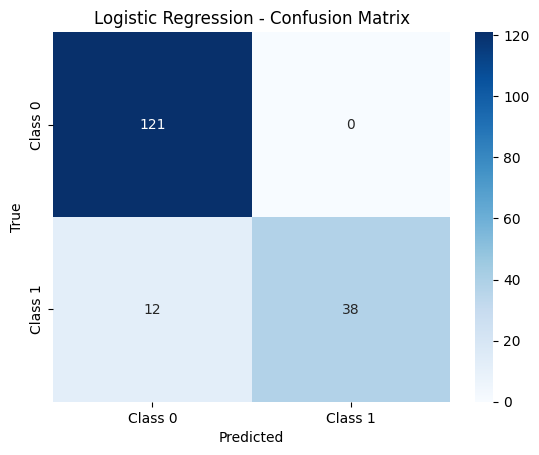


Training Random Forest...
Random Forest - ROC AUC: 0.9999, F1 Score: 0.9796


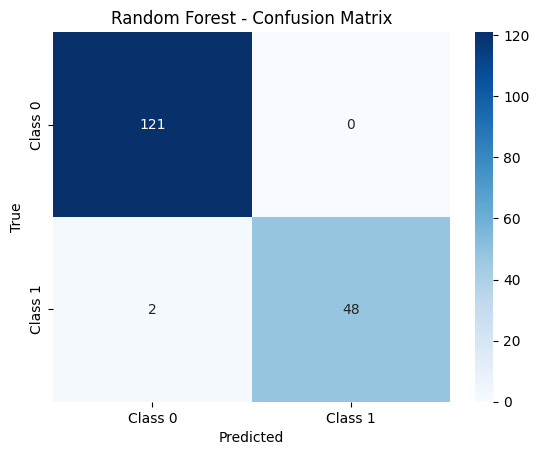


Training SVM...
SVM - ROC AUC: 0.9954, F1 Score: 0.8889


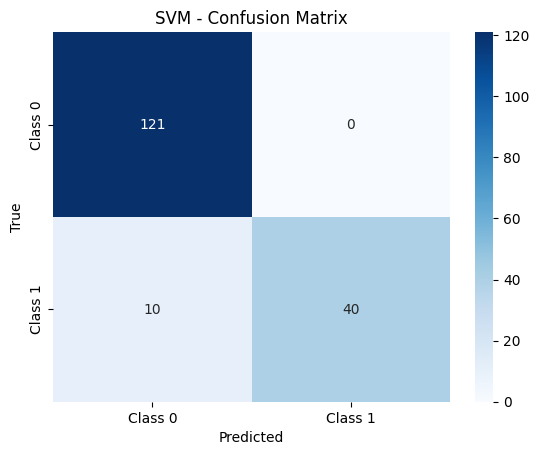


Training 1D Time Series Classifier...


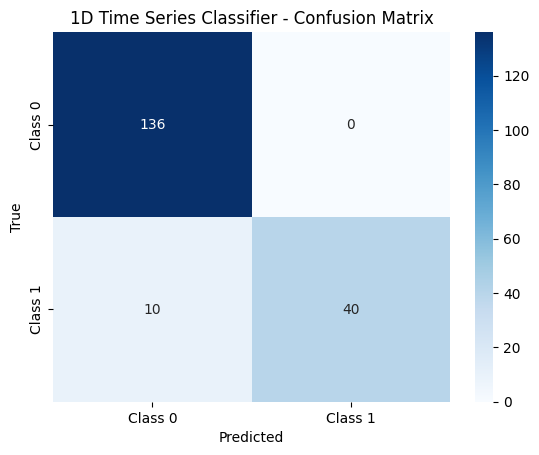

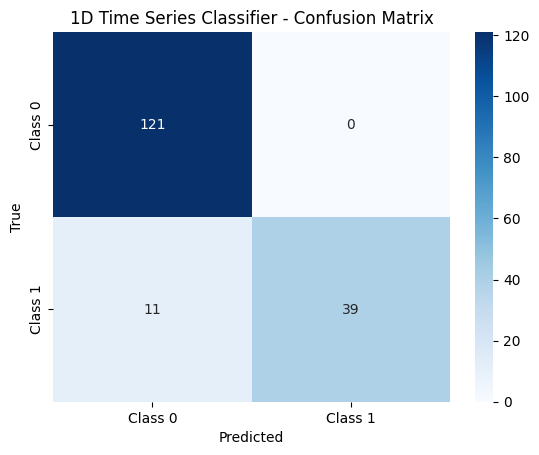

1D Time Series Classifier - ROC AUC: 0.9000, F1 Score: 0.8889
Best hyperparameters: {'window_length': 15}

Best model based on ROC AUC and F1 Score: Random Forest
Best model ROC AUC: 0.9999173553719009
Best model F1 Score: 0.9795918367346939


['best_model.pkl']

In [4]:

%load_ext autoreload
%autoreload 2

# Import necessary libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
import joblib

# Import custom functions
from ml_pipeline.featureset import make_summary_stats_input,make_series_input
from ml_pipeline.model import processing_pipeline,  train_series_model

# %% 
# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Prepare the training and testing datasets
# Dictionary to store data splits
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

# Process 'stat' dataset for training and testing
data_dict['stat']['X_train'], data_dict['stat']['y_train'] = processing_pipeline(
    train[-3100:-2900],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

data_dict['stat']['X_test'], data_dict['stat']['y_test'] = processing_pipeline(
    test[4200:4400],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    '1D Time Series Classifier':'custom'
}

# Hyperparameters for GridSearchCV
param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2', 'l1'],
        'fit_intercept': [True, False],
        'class_weight': ['balanced', None]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    },
    
    '1D Time Series Classifier': {
        'window_length': [15,30]  # Only test window lengths 30 and 60
    }
}

# To store the evaluation metrics for each model
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    if model_name == '1D Time Series Classifier':
        # GridSearch-like loop to tune window_length
        best_roc_auc = -1  # Store best ROC AUC for window length tuning
        best_f1 = -1  # Store best F1 for window length tuning
        best_model = None  # Store best model
        best_params = None  # Store best parameters

        for window_length in param_grid['1D Time Series Classifier']['window_length']:
            # Process dataset with the current window_length
            data_dict['1col']['X_train'], data_dict['1col']['y_train'] = processing_pipeline(
                train[-3100:-2900][['Temperature', 'Status']],  # Use fixed features
                window_kwargs={'window_length': window_length, 'step_length': 1, 'fh': 0},
                feature_func=make_series_input,
                add_first_diffs=False
            )
            data_dict['1col']['X_test'], data_dict['1col']['y_test'] = processing_pipeline(
                test[4200:4400][['Temperature', 'Status']],  # Use fixed features
                window_kwargs={'window_length': window_length, 'step_length': 1, 'fh': 0},
                feature_func=make_series_input,
                add_first_diffs=False
            )

            # Train the model using the current window_length
            model = train_series_model(
                X=data_dict['1col']['X_train'],
                y=data_dict['1col']['y_train']
            )

            # Make predictions and calculate evaluation metrics
            y_pred = model.predict(data_dict['1col']['X_test'])
            y_pred_proba = model.predict_proba(data_dict['1col']['X_test'])[:, 1]
            

            # Evaluate ROC AUC and F1 Score
            roc_auc = roc_auc_score(data_dict['1col']['y_test'], y_pred_proba)
            f1 = f1_score(data_dict['1col']['y_test'], y_pred)
             # Confusion Matrix Visualization
            conf_matrix = confusion_matrix(data_dict['1col']['y_test'], y_pred)
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
            plt.title(f"{model_name} - Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()
            # If this is the best result, store it
            if roc_auc > best_roc_auc and f1 > best_f1:
                best_roc_auc = roc_auc
                best_f1 = f1
                best_model = model
                best_params = {
                    'window_length': window_length
                }

        # Store the best model and metrics
        model_performance[model_name] = {
            'model': best_model,
            'roc_auc': best_roc_auc,
            'f1': best_f1,
            'params': best_params
        }

        print(f"{model_name} - ROC AUC: {best_roc_auc:.4f}, F1 Score: {best_f1:.4f}")
        print(f"Best hyperparameters: {best_params}")

    else:
        # Standard model with GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(data_dict['stat']['X_train'], data_dict['stat']['y_train'])
        
        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(data_dict['stat']['X_test'])
        y_pred_proba = best_model.predict_proba(data_dict['stat']['X_test'])[:, 1]

        # Calculate evaluation metrics
        roc_auc = roc_auc_score(data_dict['stat']['y_test'], y_pred_proba)
        f1 = f1_score(data_dict['stat']['y_test'], y_pred)

        # Store model performance
        model_performance[model_name] = {
            'model': best_model,
            'roc_auc': roc_auc,
            'f1': f1
        }

        print(f"{model_name} - ROC AUC: {roc_auc:.4f}, F1 Score: {f1:.4f}")

        # Confusion Matrix Visualization
        conf_matrix = confusion_matrix(data_dict['stat']['y_test'], y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.title(f"{model_name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

# Select the best model based on ROC AUC and F1 Score
best_model_name = max(model_performance, key=lambda x: (model_performance[x]['roc_auc'], model_performance[x]['f1']))
best_model = model_performance[best_model_name]['model']

print(f"\nBest model based on ROC AUC and F1 Score: {best_model_name}")
print(f"Best model ROC AUC: {model_performance[best_model_name]['roc_auc']}")
print(f"Best model F1 Score: {model_performance[best_model_name]['f1']}")

# Save the best model for later use
joblib.dump(best_model, 'best_model.pkl')

# Example usage of test_model (if required for '1col' or other data processing)
# Make sure to apply the necessary preprocessing steps for any additional data splits.
